In [1]:
from IPython.display import display, Image

# Capstone - CNN


In [2]:
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C

%matplotlib inline

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [7]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))
        
print(C.device.gpu(0))

ValueError: Specified GPU device id (0) is invalid.

[CALL STACK]
    > CNTK::Parameter::  SetValue
    - CNTK::DeviceDescriptor::  GPUDevice
    - PyInit__cntk_py
    - PyCFunction_FastCallDict
    - PyObject_CallFunctionObjArgs
    - PyEval_EvalFrameDefault
    - Py_CheckFunctionResult
    - PyList_Size
    - PyEval_EvalFrameDefault
    - Py_CheckFunctionResult
    - PyObject_CallFunctionObjArgs
    - PyEval_EvalFrameDefault
    - Py_CheckFunctionResult
    - PyEval_GetGlobals (x2)
    - PyCFunction_FastCallDict



In [8]:
# Test for CNTK version
if not C.__version__ == "2.0":
    raise Exception("this notebook is designed to work with 2.0. Current Version: " + C.__version__) 

Exception: this notebook is designed to work with 2.0. Current Version: 2.5.1

In [5]:
# Ensure we always get the same amount of randomness
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Define the data dimensions
input_dim_model = (1, 64, 64)    # images are 64 x 64 with 1 channel of color (gray)
input_dim = 64*64                # used by readers to treat input data as a vector
num_output_classes = 4

In [6]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [7]:
# Ensure the training and test data is available
# We search in two locations in the toolkit for the cached MNIST data set.

data_found=False # A flag to indicate if train/test data found in local cache
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("Capstone")]:
    
    train_file=os.path.join(data_dir, "Train_data.txt")
    test_file=os.path.join(data_dir, "Validation_data.txt")
    
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found=True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing Capstone_DataLoader")
    
print("Data directory is {0}".format(data_dir))

Data directory is Capstone


In [8]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

In [9]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.leaky_relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=25, #8
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=50, #16
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=100, #16
                                       strides=(2,2), 
                                       pad=True, name='third_conv')(h)
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
            return r

In [10]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
print("Output Shape of the second convolution layer:", z.second_conv.shape)
print("Output Shape of the third convolution layer:", z.third_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

Output Shape of the first convolution layer: (25, 32, 32)
Output Shape of the second convolution layer: (50, 16, 16)
Output Shape of the third convolution layer: (100, 8, 8)
Bias value of the last dense layer: [0. 0. 0. 0.]


In [11]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 82254 parameters in 8 parameter tensors.


## Training

We minimize the cross-entropy between the label and predicted probability by the network. Since we are going to build more than one model, we will create a few helper functions.

In [12]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

Next we will need a helper function to perform the model training. First let us create additional helper functions that will be needed to visualize different functions associated with training.

In [13]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

### Configure training

Previously we have described the concepts of `loss` function, the optimizers or [learners](https://cntk.ai/pythondocs/cntk.learners.html) and the associated machinery needed to train a model. Please refer to earlier labs for gaining familiarility with these concepts. Here we combine model training and testing in a helper function below. 


In [14]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=20):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 255.
    model = model_func(x/255)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = 0.005
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 128
    num_samples_per_sweep = 20000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 100
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 512
    num_samples = 20000
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

<a id='#Run the trainer'></a>
### Run the trainer and test model

We are now ready to train our convolutional neural net. 

In [48]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 1.3902, Error: 79.69%
Minibatch: 500, Loss: 0.8459, Error: 23.44%
Minibatch: 1000, Loss: 0.3876, Error: 9.38%
Minibatch: 1500, Loss: 0.2961, Error: 9.38%
Minibatch: 2000, Loss: 0.3593, Error: 17.19%
Minibatch: 2500, Loss: 0.3185, Error: 10.94%


SystemError: <built-in function MinibatchSource_get_next_minibatch> returned a result with an error set

Note, the average test error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a. [generalization error](https://en.wikipedia.org/wiki/Generalization_error). This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).

Let us check what is the value of some of the network parameters. We will check the bias value of the output dense layer. Previously, it was all 0. Now you see there are non-zero values, indicating that a model parameters were updated during training.

In [27]:
print("Bias value of the last dense layer:", z.classify.b.value)

Bias value of the last dense layer: [-0.00447022 -0.0033466  -0.00136732  0.00918391]


## Evaluation / Prediction
We have so far been dealing with aggregate measures of error. Let us now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifier is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the network to probabilities across the 10 classes.

In [51]:
out = C.softmax(z)

Let us test a small minibatch sample from the test data.

In [9]:
# Read the data for evaluation
capstone_file=os.path.join(data_dir, "train_data.txt")
reader_eval=create_reader(capstone_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {x: reader_eval.streams.features, y:reader_eval.streams.labels} 

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

# reshape img_data to: M x 1 x 28 x 28 to be compatible with model
img_data = np.reshape(img_data, (eval_minibatch_size, 1, 64, 64))
print(z.eval(img_data[img_data[0]]))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

NameError: name 'data_dir' is not defined

In [53]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]
print(pred[0:15])
print(gtlabel[0:15])

[1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 3, 2, 3, 2, 1, 0, 0, 0, 1, 3, 0, 2, 0, 1]


In [41]:
with open('Capstone\Test_results.csv', 'w') as result_file:
        result_file.write('id,orientation\n')  
        for prediction in range(len(pred)):
            result_file.write('{},{}\n'.format(str(prediction+200000),str(pred[prediction])))


Let us visualize some of the results

Image Label:  1


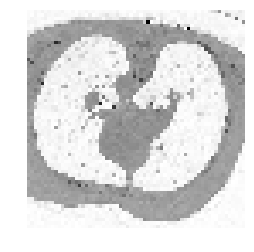

In [46]:
# Plot a random image
sample_number = 4
plt.imshow(img_data[sample_number].reshape(64,64), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

## Pooling Layer

Often times, one needs to control the number of parameters especially when having deep networks. For every layer of the convolution layer output (each layer, corresponds to the output of a filter), one can have a pooling layer. Pooling layers are typically introduced to:
- Reduce the shape of the current layer (speeding up the network),
- Make the model more tolerant to changes in object location in the image. For example, even when a digit is shifted to one side of the image instead of being in the middle, the classifer would perform the classification task well.

The calculation on a pooling node is much simpler than a normal feedforward node.  It has no weight, bias, or activation function.  It uses a simple aggregation function (like max or average) to compute its output.  The most commonly used function is "max" - a max pooling node simply outputs the maximum of the input values corresponding to the filter position of the input. The figure below shows the input values in a 4 x 4 region. The max pooling window size is 2 x 2 and starts from the top left corner, and uses a stride of 2x2.  The maximum value within the window becomes the output of the region. Every time the model is shifted by the amount specified by the stride parameter (as shown in the figure below) and the maximum pooling operation is repeated. 
![maxppool](https://cntk.ai/jup/201/MaxPooling.png)

Another alternative is average pooling, which emits that average value instead of the maximum value. The two different pooling opearations are summarized in the animation below.

In [62]:
# Modify this model
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=8, 
                                       strides=(1,1), 
                                       pad=True, name='first_conv')(h)
            #h = C.layers.AveragePooling(filter_shape=(3,3), 
            #                            strides=(2,2),
            #                            name='first_pool')(h)        
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=16, 
                                       strides=(1,1), 
                                       pad=True, name='second_conv')(h)
            h = C.layers.AveragePooling(filter_shape=(3,3), 
                                        strides=(2,2),
                                        name='second_pool')(h)        
            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r
        
do_train_test()

Minibatch: 0, Loss: 1.4093, Error: 77.34%
Minibatch: 500, Loss: 0.4811, Error: 19.92%
Minibatch: 1000, Loss: 0.2587, Error: 7.03%
Minibatch: 1500, Loss: 0.2762, Error: 9.38%
Minibatch: 2000, Loss: 0.3270, Error: 16.80%
Minibatch: 2500, Loss: 0.2959, Error: 10.94%
Minibatch: 3000, Loss: 0.1221, Error: 5.08%
Minibatch: 3500, Loss: 0.1536, Error: 5.86%
Minibatch: 4000, Loss: 0.1252, Error: 3.91%
Minibatch: 4500, Loss: 0.1288, Error: 3.91%
Minibatch: 5000, Loss: 0.0933, Error: 3.12%
Minibatch: 5500, Loss: 0.1238, Error: 3.12%
Minibatch: 6000, Loss: 0.0635, Error: 1.56%
Minibatch: 6500, Loss: 0.1287, Error: 3.91%
Minibatch: 7000, Loss: 0.0786, Error: 1.95%
Minibatch: 7500, Loss: 0.1069, Error: 3.12%
Minibatch: 8000, Loss: 0.1182, Error: 4.69%
Minibatch: 8500, Loss: 0.1911, Error: 6.25%
Minibatch: 9000, Loss: 0.1351, Error: 4.30%
Minibatch: 9500, Loss: 0.0889, Error: 1.56%
Minibatch: 10000, Loss: 0.0948, Error: 2.73%
Minibatch: 10500, Loss: 0.0389, Error: 1.17%
Minibatch: 11000, Loss: 0.1246

In [45]:
C.logging.log_number_of_parameters(z)


Training 14244 parameters in 6 parameter tensors.


In [ ]:
pred


In [63]:
# Modify this model
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform(), activation = C.relu):
            h = features
            
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=25, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=50, 
                                       strides=(1,1), 
                                       pad=True, name='second_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2),
                                        name='first_pool')(h)        
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=100, 
                                       strides=(2,2), 
                                       pad=True, name='third_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                       name='second_pool')(h)    
            h = C.layers.Convolution2D(filter_shape=(3,3), 
                                       num_filters=200, 
                                       strides=(2,2), 
                                       pad=True, name='fourth_conv')(h)
            h = C.layers.MaxPooling(filter_shape=(2,2), 
                                       name='second_pool')(h)
            r = C.layers.Dense(num_output_classes, activation = None, name='classify')(h)
            return r
        
do_train_test()

Minibatch: 0, Loss: 1.3911, Error: 78.52%
Minibatch: 500, Loss: 0.6528, Error: 25.00%
Minibatch: 1000, Loss: 0.1934, Error: 7.81%
Minibatch: 1500, Loss: 0.1208, Error: 3.52%
Minibatch: 2000, Loss: 0.1298, Error: 4.30%
Minibatch: 2500, Loss: 0.0787, Error: 1.17%
Minibatch: 3000, Loss: 0.0280, Error: 0.39%
Minibatch: 3500, Loss: 0.0407, Error: 1.56%
Minibatch: 4000, Loss: 0.0524, Error: 1.56%
Minibatch: 4500, Loss: 0.0888, Error: 2.34%
Minibatch: 5000, Loss: 0.0381, Error: 1.56%
Minibatch: 5500, Loss: 0.0577, Error: 2.34%
Minibatch: 6000, Loss: 0.0196, Error: 0.78%
Minibatch: 6500, Loss: 0.0568, Error: 0.78%
Minibatch: 7000, Loss: 0.0226, Error: 0.78%
Minibatch: 7500, Loss: 0.0344, Error: 0.78%


SystemError: <built-in function MinibatchSource_get_next_minibatch> returned a result with an error set

In [ ]:
C.logging.graph.plot(model, 'model.png')

In [15]:
def convolution_bn(input, filter_size, num_filters, strides=(1,1), init=C.he_normal(), activation=C.relu):
    if activation is None:
        activation = lambda x: x

    r = C.layers.Convolution(filter_size,
                             num_filters,
                             strides=strides,
                             init=init,
                             activation=None,
                             pad=True, bias=False)(input)
    r = C.layers.BatchNormalization(map_rank=1)(r)
    r = activation(r)

    return r

def resnet_basic(input, num_filters):
    c1 = convolution_bn(input, (3,3), num_filters)
    c2 = convolution_bn(c1, (3,3), num_filters, activation=None)
    p  = c2 + input
    return C.relu(p)

def resnet_basic_inc(input, num_filters):
    c1 = convolution_bn(input, (3,3), num_filters, strides=(2,2))
    c2 = convolution_bn(c1, (3,3), num_filters, activation=None)

    s = convolution_bn(input, (1,1), num_filters, strides=(2,2), activation=None)

    p = c2 + s
    return C.relu(p)

def resnet_basic_stack(input, num_filters, num_stack):
    assert (num_stack > 0)

    r = input
    for _ in range(num_stack):
        r = resnet_basic(r, num_filters)
    return r

In [16]:

def create_resnet_model(input):
    conv = convolution_bn(input, (3,3), 16)
    r1_1 = resnet_basic_stack(conv, 16, 3)

    r2_1 = resnet_basic_inc(r1_1, 32)
    r2_2 = resnet_basic_stack(r2_1, 32, 2)

    r3_1 = resnet_basic_inc(r2_2, 64)
    r3_2 = resnet_basic_stack(r3_1, 64, 2)

    # Global average pooling
    pool = C.layers.AveragePooling(filter_shape=(8,8), strides=(1,1))(r3_2)
    net = C.layers.Dense(num_output_classes, init=C.he_normal(), activation=None)(pool)

    return net

def do_train_test_ResNet():
    global z
    z = create_resnet_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    


In [17]:

do_train_test_ResNet()

Minibatch: 0, Loss: 2.0070, Error: 76.56%
Minibatch: 100, Loss: 0.3734, Error: 8.59%
Minibatch: 200, Loss: 0.1959, Error: 3.91%
Minibatch: 300, Loss: 0.1174, Error: 4.69%
Minibatch: 400, Loss: 0.0752, Error: 1.56%
Minibatch: 500, Loss: 0.1610, Error: 4.69%
Minibatch: 600, Loss: 0.2099, Error: 1.56%
Minibatch: 700, Loss: 0.0595, Error: 3.12%
Minibatch: 800, Loss: 0.1320, Error: 2.34%
Minibatch: 900, Loss: 0.0450, Error: 0.78%
Minibatch: 1000, Loss: 0.0453, Error: 1.56%
Minibatch: 1100, Loss: 0.0337, Error: 0.78%
Minibatch: 1200, Loss: 0.0082, Error: 0.00%
Minibatch: 1300, Loss: 0.0256, Error: 0.00%
Minibatch: 1400, Loss: 0.0354, Error: 0.00%
Minibatch: 1500, Loss: 0.0355, Error: 1.56%
Minibatch: 1600, Loss: 0.0371, Error: 1.56%
Minibatch: 1700, Loss: 0.0077, Error: 0.00%
Minibatch: 1800, Loss: 0.0284, Error: 0.78%
Minibatch: 1900, Loss: 0.0323, Error: 0.78%
Minibatch: 2000, Loss: 0.0098, Error: 0.00%
Minibatch: 2100, Loss: 0.0086, Error: 0.00%
Minibatch: 2200, Loss: 0.0058, Error: 0.00%

In [56]:
print(z)

Composite(Tensor[1,64,64]) -> Tensor[4]
